# Notebook to find QC Covariates on raw data

**Created by :** Srivalli Kolla

**Created on :** 13 May, 2025

**Modified on :** 13 May, 2025

**University of Würzburg**

Env : scanpy (Python 3.12.2)

# Importing Packages

In [1]:
import anndata
import logging
import scanpy as sc
import seaborn as sb
import pandas as pd
import numpy as np
import datetime
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()

plt.rcParams['figure.dpi'] = 300  
plt.rcParams['savefig.dpi'] = 300

timestamp = datetime.datetime.now().strftime("%d_%m_%y")

-----
anndata     0.11.3
scanpy      1.10.4
-----
Cython                      3.0.12
PIL                         11.1.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        25.1.0
attrs                       25.1.0
babel                       2.17.0
certifi                     2025.01.31
charset_normalizer          3.4.1
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython                      3.0.12
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.12
decorator                   5.2.1
defusedxml                  0.7.1
executing                   2.1.0
fastjsonschema              NA
fqdn                        NA
h5py                        3.13.0
idna                        3.10
igraph                      0.11.8
ipykernel                   6.29.5
ipywidgets                  8.1.5
isoduration               

/home/gruengroup/srivalli/miniconda3/envs/scanpy/lib/python3.13/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


## Read `anndata` objects

In [3]:
cd 'Github/Matthias_sn_data_2025'

/home/gruengroup/srivalli/Github/Matthias_sn_data_2025


In [4]:
adata = sc.read_h5ad('./data/matthias_raw_basic_qc_13_05_25.h5ad')
adata

AnnData object with n_obs × n_vars = 79592 × 32285
    obs: 'sample_name', 'Genotype', 'Sample_ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw_counts'

# Doublet Scores Prediction

#### Steps followed

Make a loop to work on all the samples

1. List of samples
2. Subsetting samples based on sample_name
3. Doublet score calculation
4. Assign doublet scores to the sample
5. Plotting

In [5]:
sample_names = adata.obs['Sample_ID'].unique()

for sample_name in sample_names:
    mask = adata.obs['Sample_ID'] == sample_name
    sample_adata = adata[mask].copy()

    scrub = scr.Scrublet(sample_adata.X)

    sample_adata.obs['doublet_scores'], sample_adata.obs['predicted_doublets'] = scrub.scrub_doublets()

    adata.obs.loc[mask, 'doublet_scores'] = sample_adata.obs['doublet_scores']
    adata.obs.loc[mask, 'predicted_doublets'] = sample_adata.obs['predicted_doublets']

    #scrub.plot_histogram()

    #plt.show()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.20
Detected doublet rate = 16.6%
Estimated detectable doublet fraction = 55.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 29.9%
Elapsed time: 31.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.26
Detected doublet rate = 7.5%
Estimated detectable doublet fraction = 49.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.2%
Elapsed time: 14.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.20
Detected doublet rate = 14.4%
Estimated detectable doublet fraction = 56.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 25.5%
Elapsed time: 31.7 seconds
Preprocessing...
Simulatin

## Checking the count and percentage of Doublets - Anndata level

In [6]:
doub_tab = pd.crosstab(adata.obs['Sample_ID'],adata.obs['predicted_doublets'])
doub_tab.sum()

predicted_doublets
False    69822
True      9770
dtype: int64

In [7]:
true_doublets = adata.obs['predicted_doublets'] == True
true_doublets_count = true_doublets.sum()

true_doublets_percentage = (true_doublets_count / len(adata.obs)) * 100

true_doublets_count ,true_doublets_percentage

(np.int64(9770), np.float64(12.275103025429692))

## Checking the count of Doublets - Sample level

In [8]:
doublet_counts_per_sample = adata.obs.groupby(['Sample_ID'])['predicted_doublets'].sum()

print(doublet_counts_per_sample)

Sample_ID
D11_KDM6A_WT    4220
E5_KDM6A_KO     1220
E6_KDM6A_KO     3948
E7_KDM6A_WT      382
Name: predicted_doublets, dtype: object


/tmp/ipykernel_223357/1523542593.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  doublet_counts_per_sample = adata.obs.groupby(['Sample_ID'])['predicted_doublets'].sum()


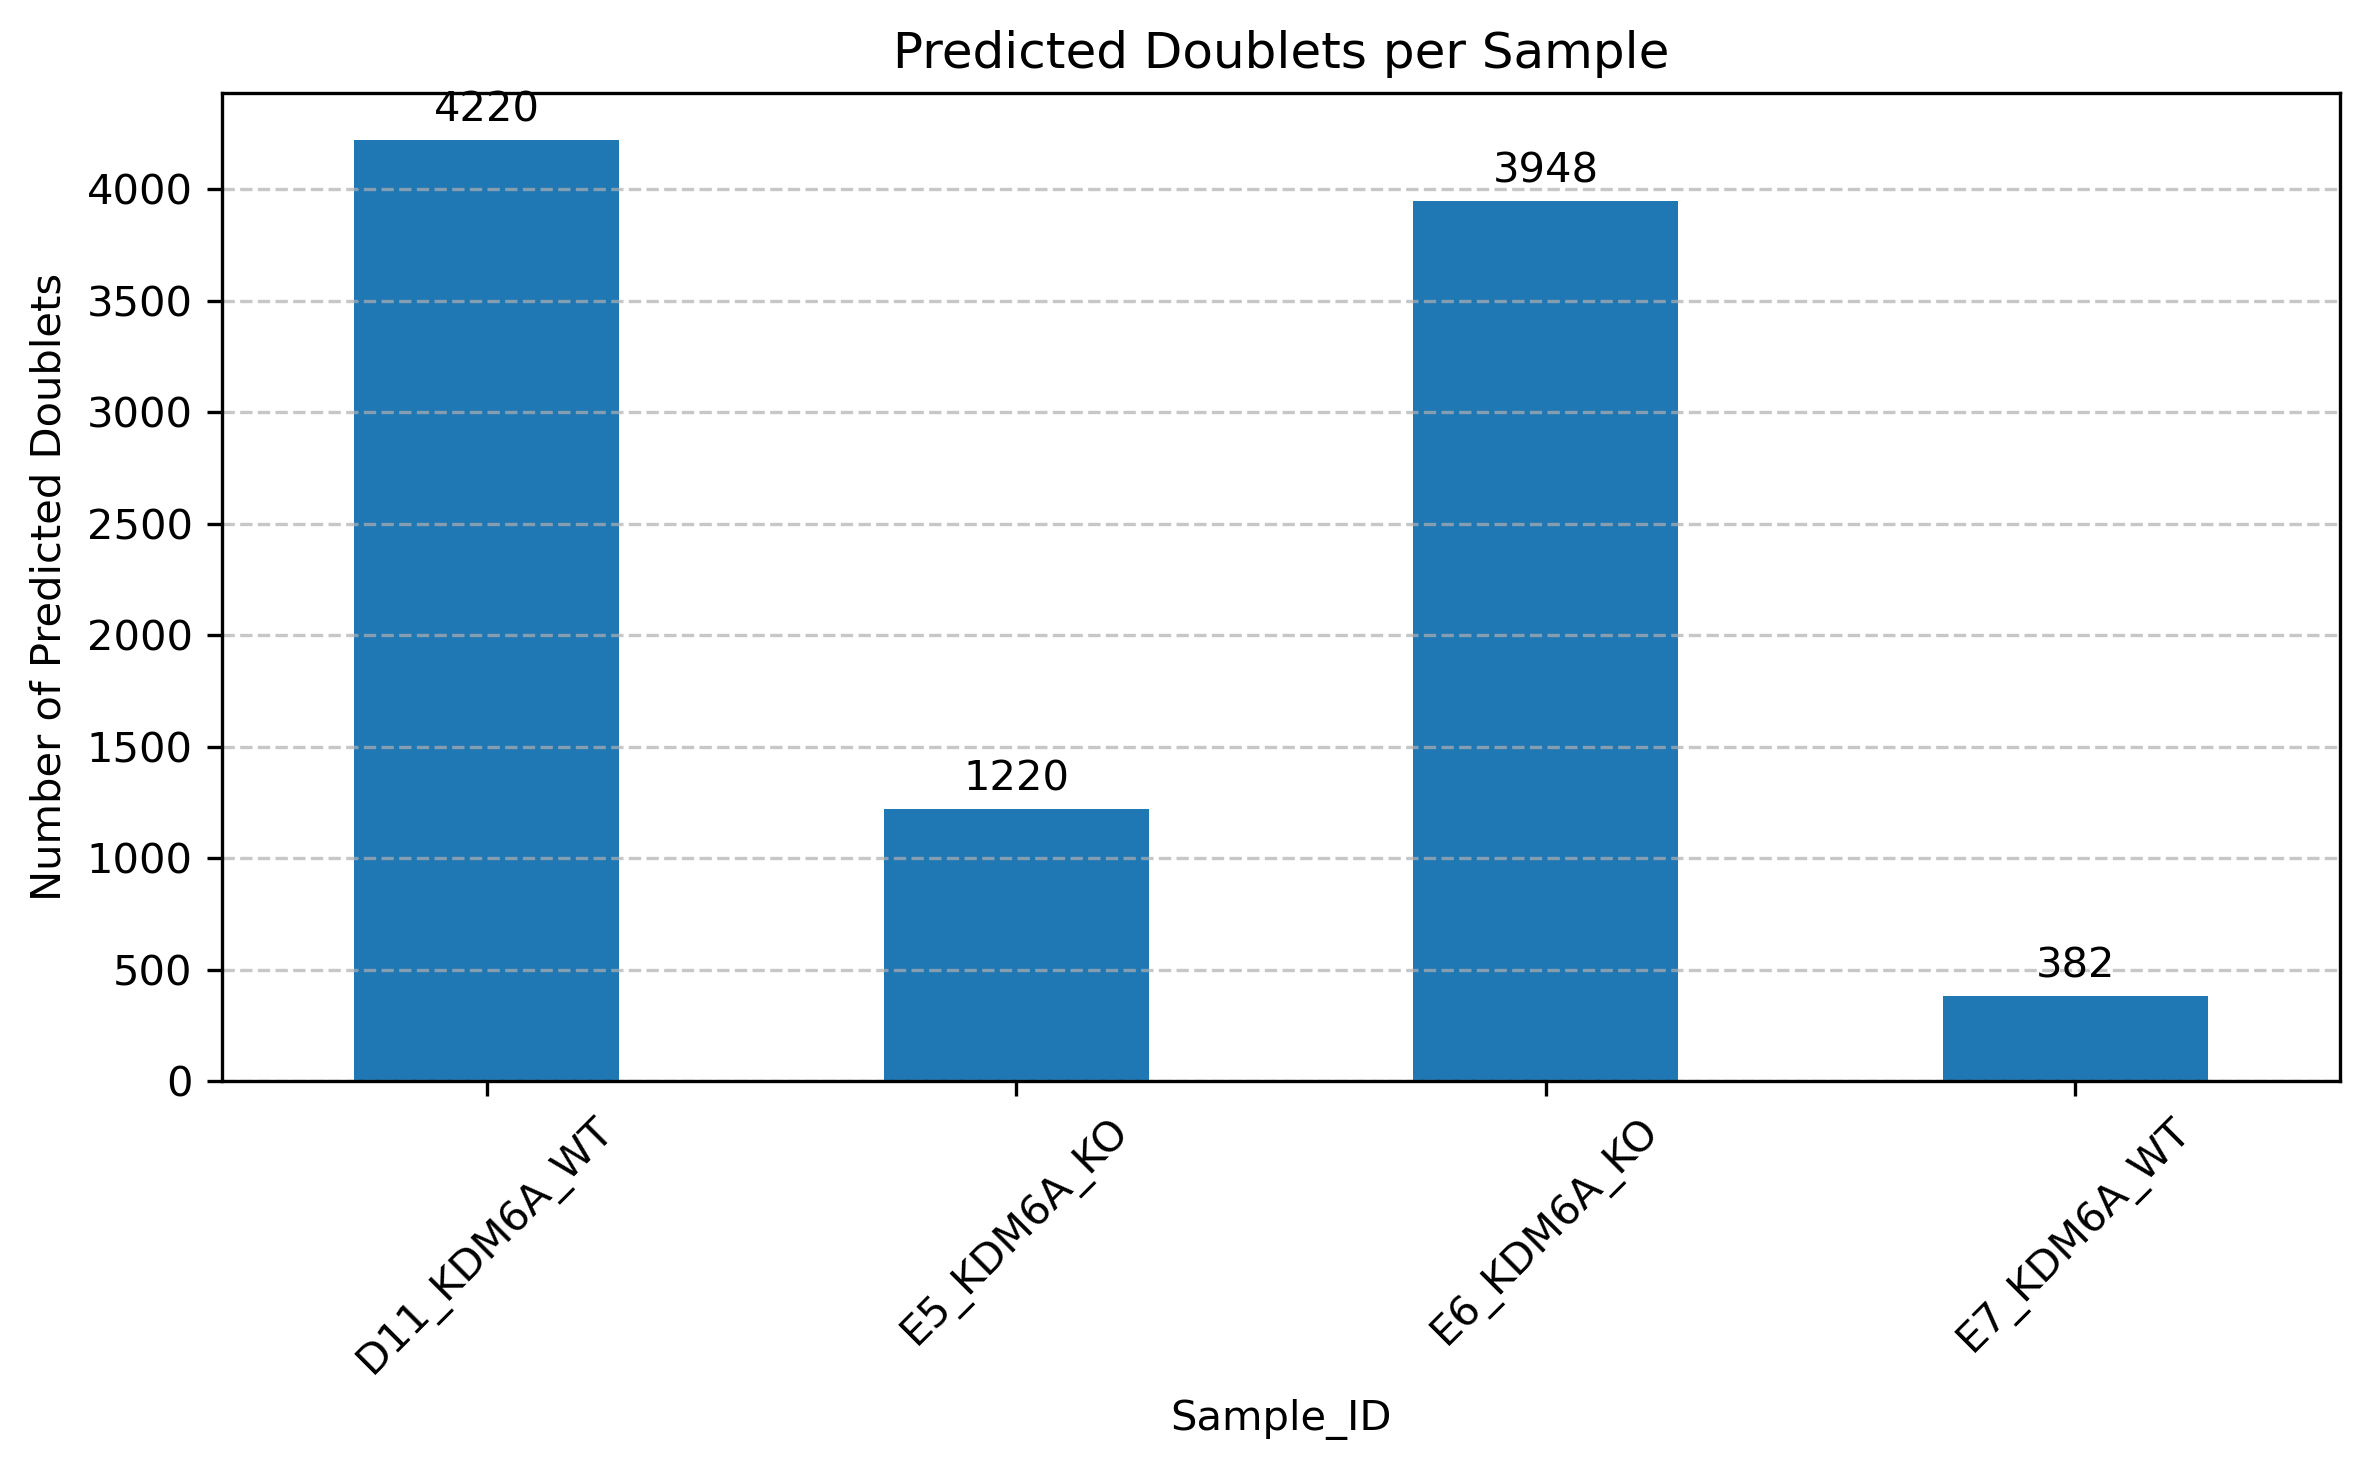

In [9]:
plt.figure(figsize=(8, 5))
ax = doublet_counts_per_sample.plot(kind='bar')

plt.title('Predicted Doublets per Sample')
plt.ylabel('Number of Predicted Doublets')
plt.xlabel('Sample_ID')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
for i, value in enumerate(doublet_counts_per_sample):
    plt.text(i, value + 0.01 * max(doublet_counts_per_sample), f"{int(value)}", 
             ha='center', va='bottom', fontsize=10)

plt.show()

Text(0.5, 1.0, 'Doublet scores - Samples')

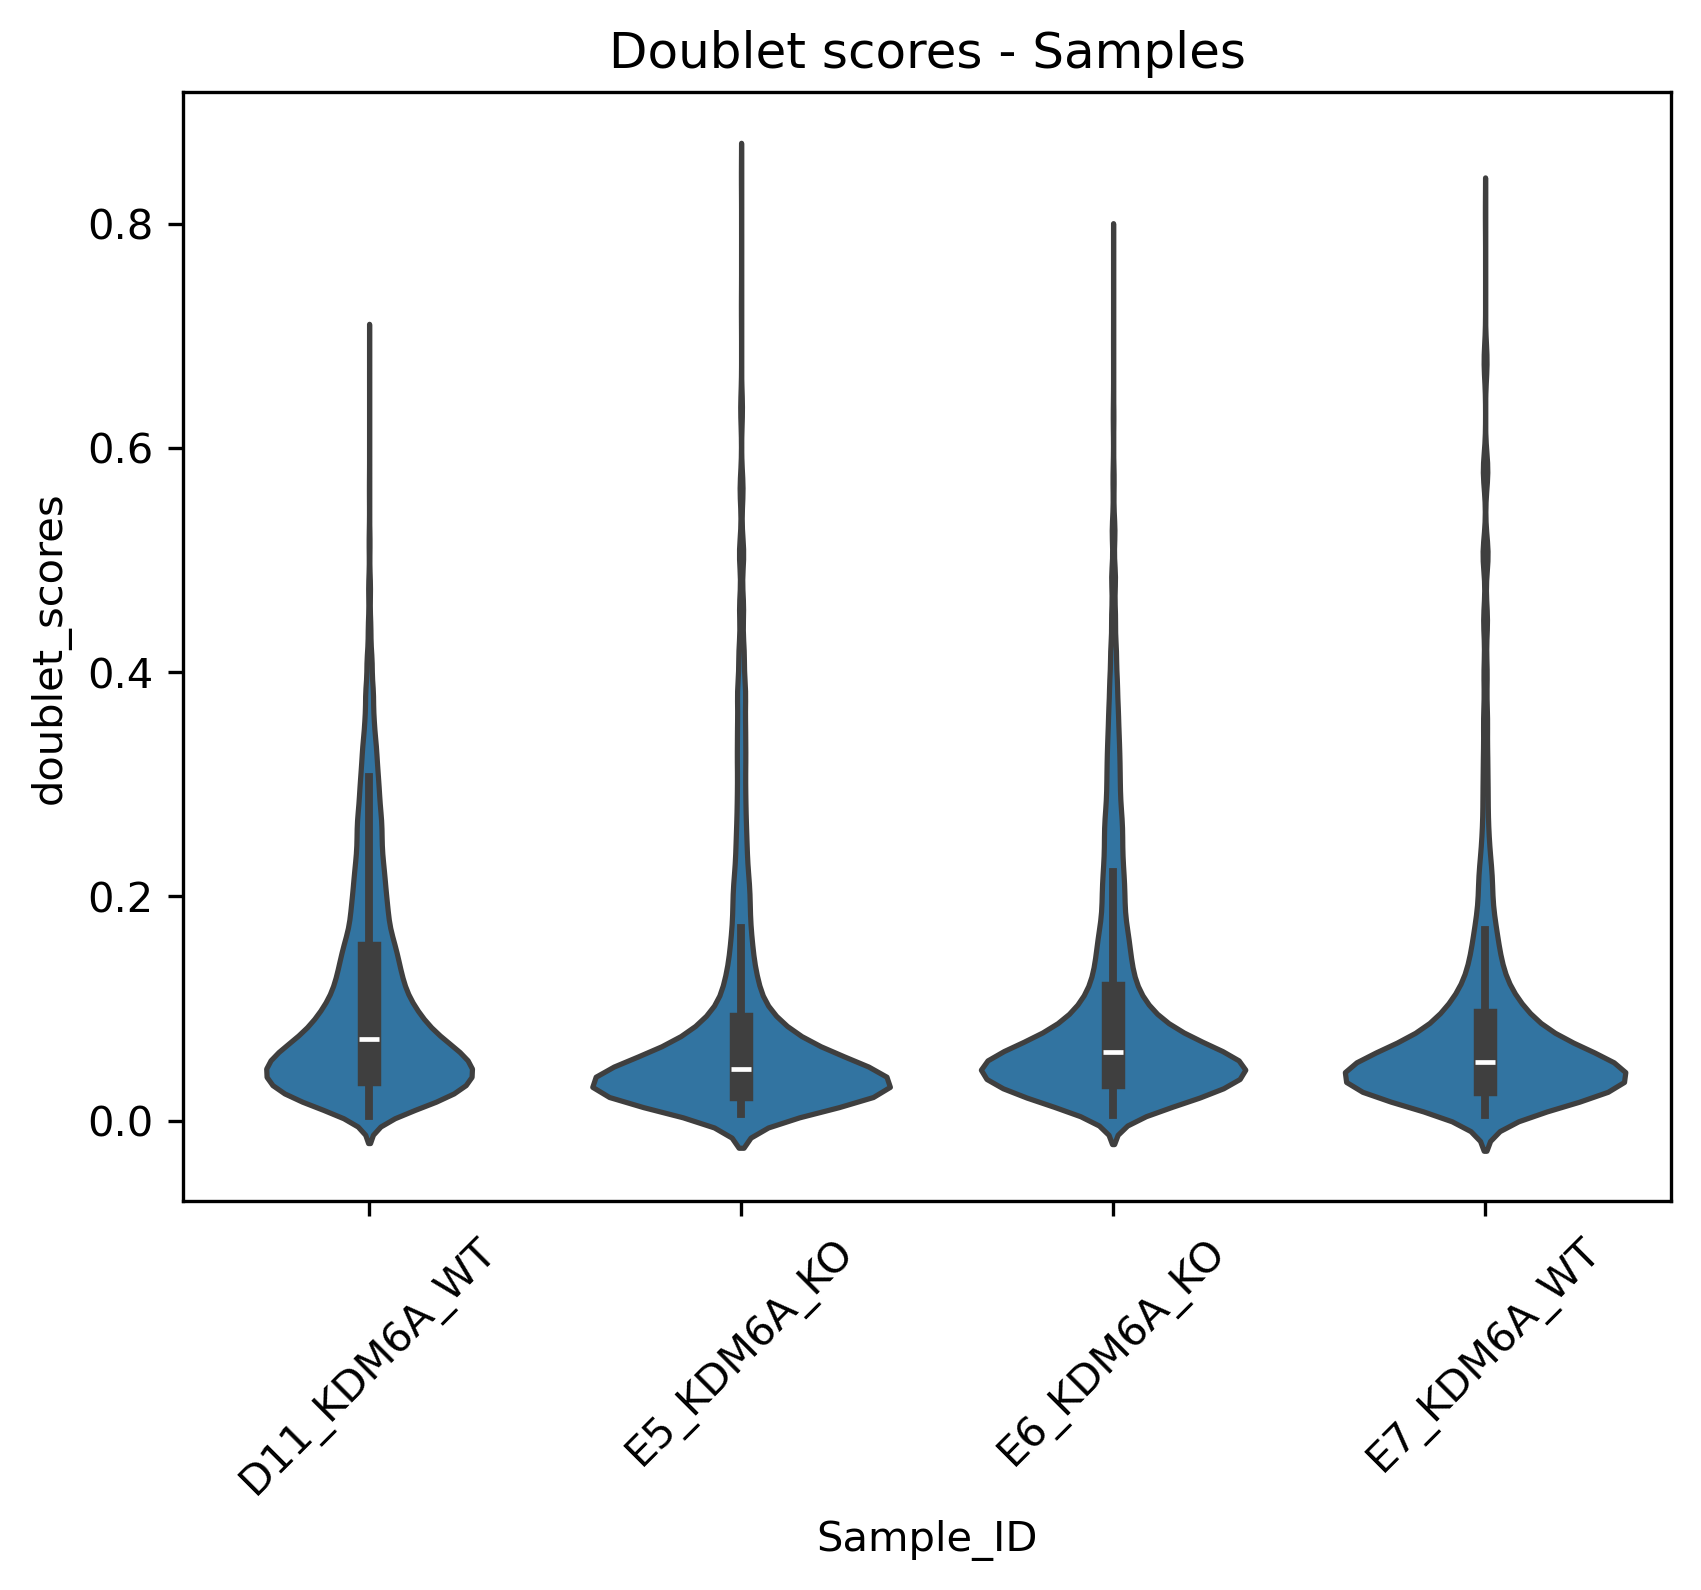

In [10]:
sb.violinplot(x=adata.obs['Sample_ID'], y=adata.obs['doublet_scores'])
plt.xticks(rotation = 45)
plt.title('Doublet scores - Samples')

# Gender covariate analysis

### Ensembl annotations

In [11]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [12]:
annot.head()

,ensembl_gene_id,start_position,end_position,chromosome_name
external_gene_name,,,,
mt-Tf,ENSMUSG00000064336,1,68,MT
mt-Rnr1,ENSMUSG00000064337,70,1024,MT
mt-Tv,ENSMUSG00000064338,1025,1093,MT
mt-Rnr2,ENSMUSG00000064339,1094,2675,MT
mt-Tl1,ENSMUSG00000064340,2676,2750,MT


## Chr Y genes calculation

In [13]:
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['Gm29089', 'Zfy1', 'Uba1y', 'Gm28588', 'Gm28587', 'Kdm5d', 'Eif2s3y',
       'Gm29650', 'Uty', 'Ddx3y',
       ...
       'Gm28672', 'Gm28670', 'Gm28673', 'Gm28674', 'Gm21996', 'Gm28930',
       'Gm29504', 'Gm20837', 'Gm28300', 'Gm28301'],
      dtype='object', length=709)

In [14]:
adata.obs['percent_chrY'] = np.sum(
    adata[:, chrY_genes].X, axis = 1) / np.sum(adata.X, axis = 1) * 100

## XIST counts

#### Steps followed

1. Select variables having 'xist' in var_names
2. Counts and percentage of XIST 
3. Creating a series to store data
4. Assigning the series back to our data into obs

In [15]:
xist_counts = adata.X[:, adata.var_names.str.match('Xist')].toarray()
xist_percentage = (np.sum(xist_counts, axis=1) / adata.obs['total_counts']) * 100

xist_counts_series = pd.Series(xist_counts.squeeze(), index = adata.obs_names, name = "XIST-counts")
xist_percentage_series = pd.Series(xist_percentage, index=adata.obs_names, name="percent_XIST")

adata.obs["XIST-counts"] = xist_counts_series
adata.obs["XIST-percentage"] = xist_percentage_series

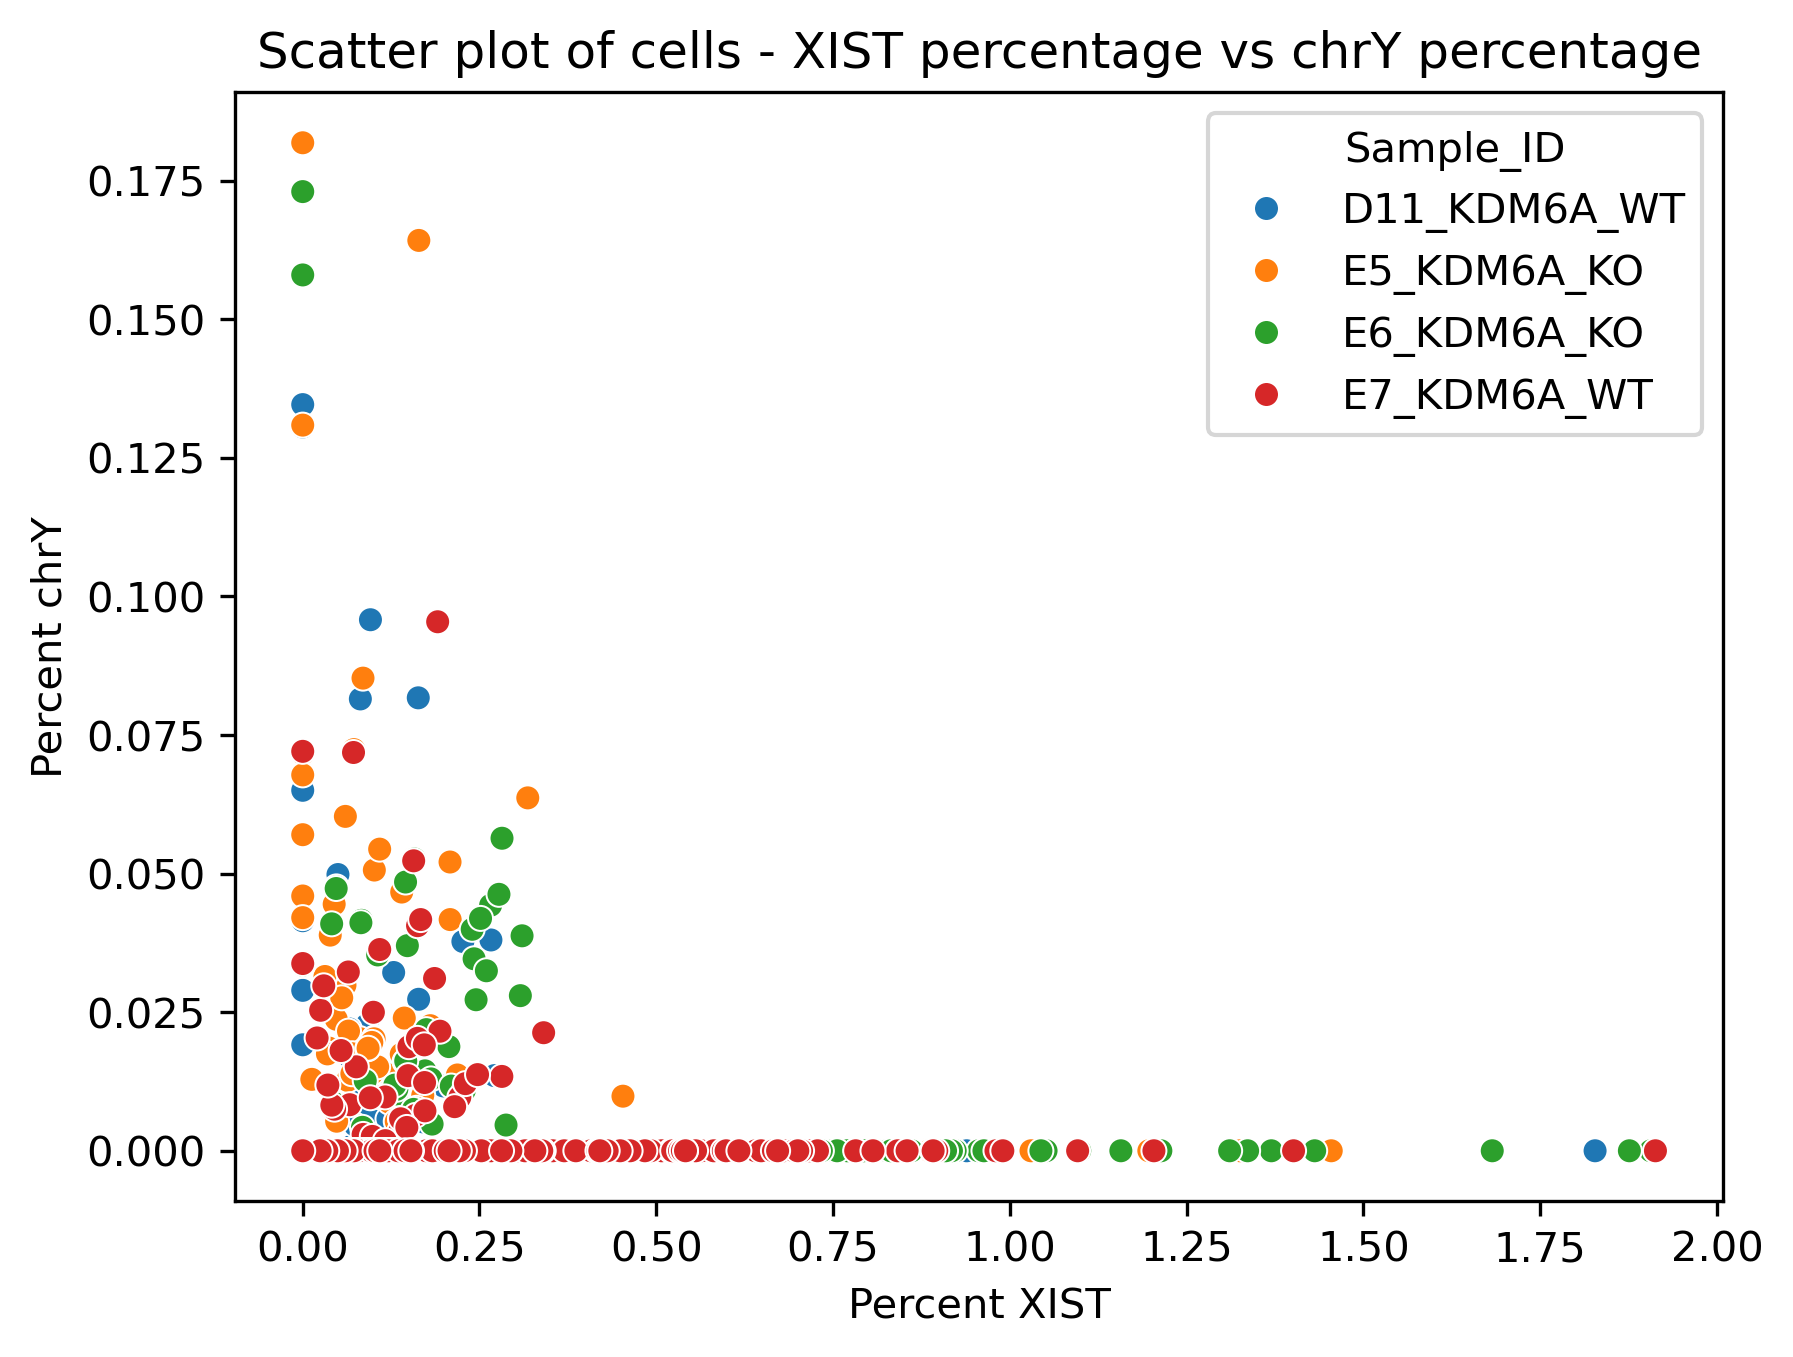

In [16]:
sb.scatterplot(data=adata.obs, x="XIST-percentage", y='percent_chrY', hue='Sample_ID')
plt.xlabel('Percent XIST')
plt.ylabel('Percent chrY')
plt.title('Scatter plot of cells - XIST percentage vs chrY percentage')
plt.legend(title='Sample_ID')
plt.show()

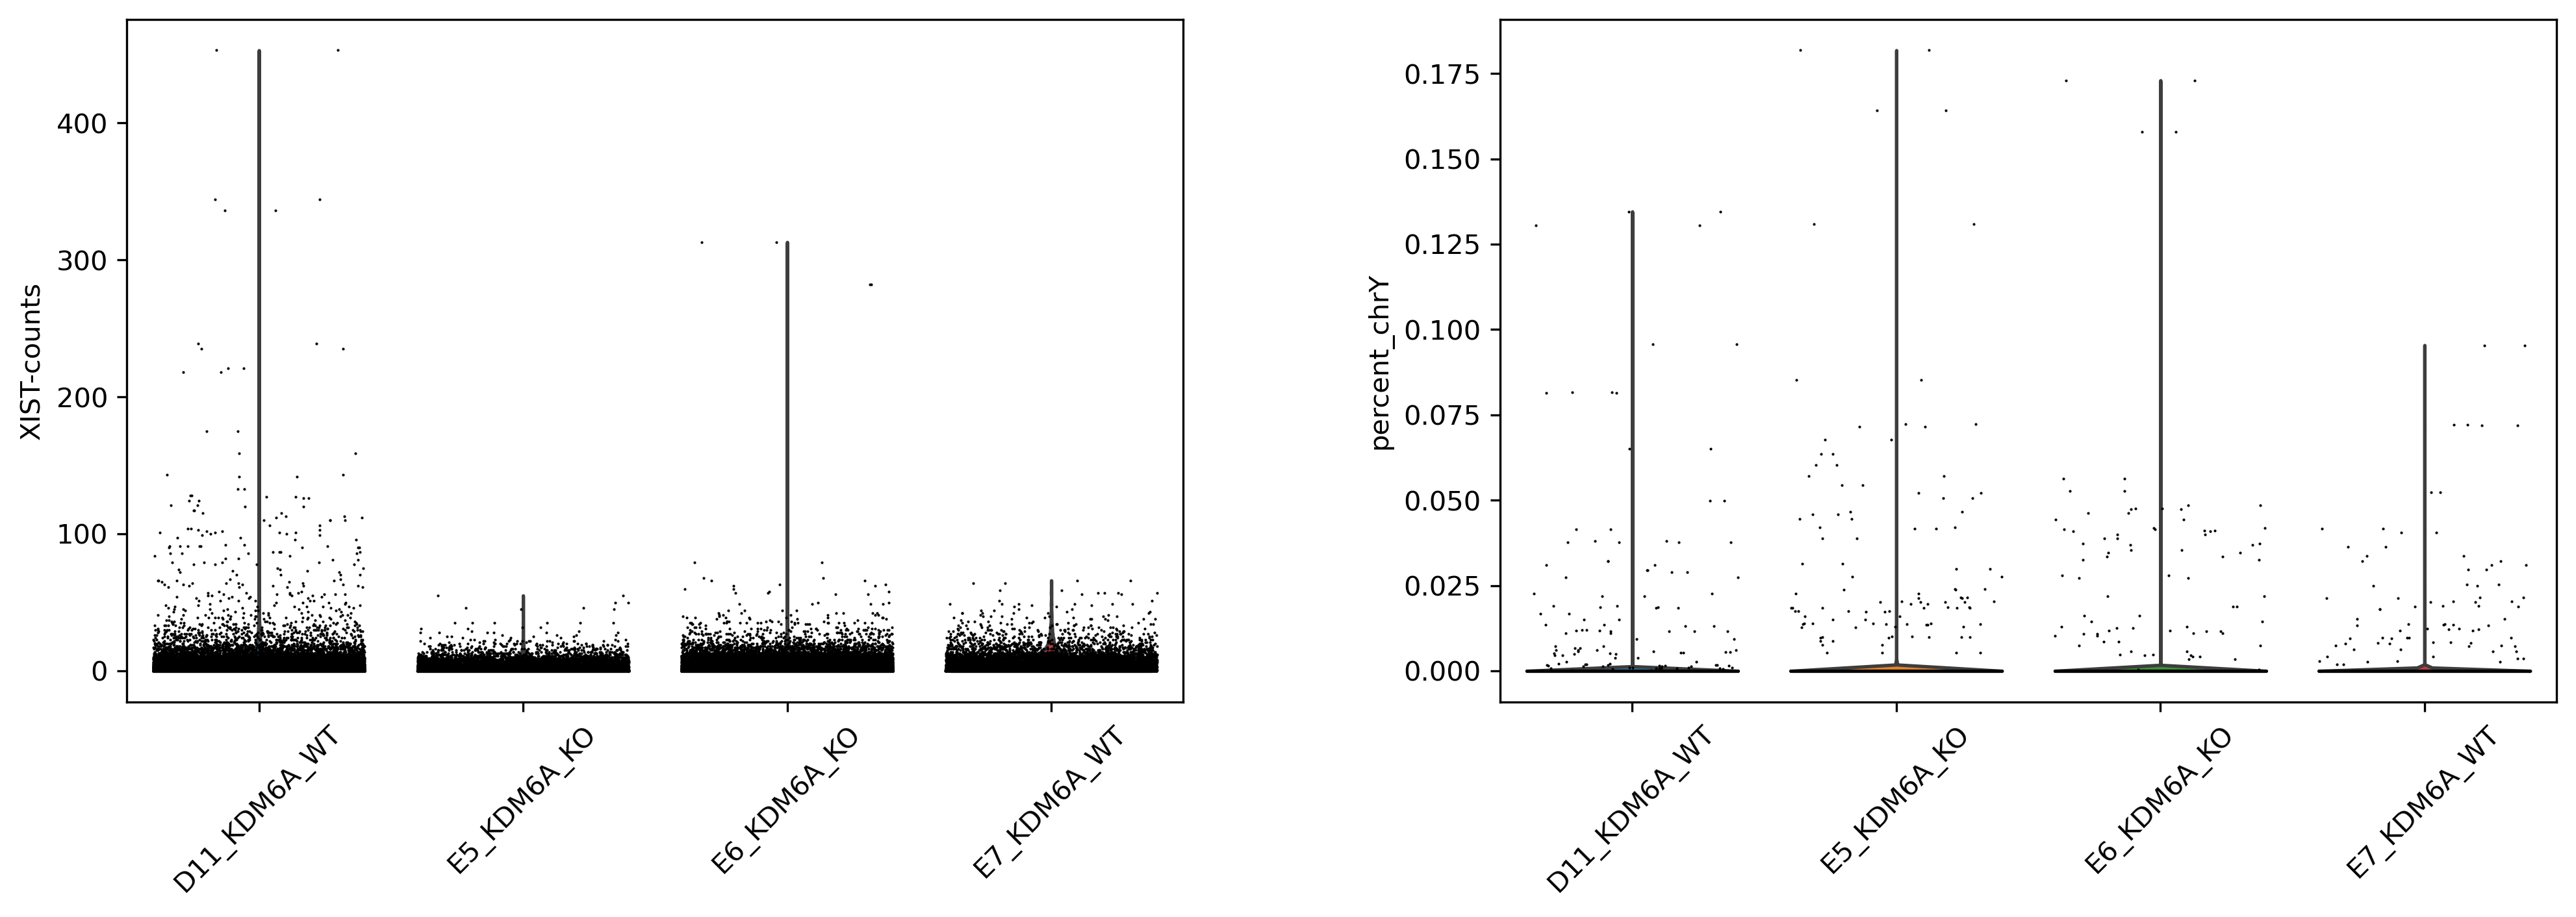

In [17]:
sc.pl.violin(adata, ["XIST-counts", "percent_chrY"], jitter = 0.4, groupby= 'Sample_ID', rotation = 45)

## Validation of sex covariates

In [18]:
zero_y_counts = len(adata.obs[adata.obs['percent_chrY'] == 0])
zero_xist_counts = len(adata.obs[adata.obs['XIST-percentage'] == 0])
both_zero_counts = len(adata.obs[(adata.obs['percent_chrY'] == 0) & (adata.obs['XIST-percentage'] == 0)])

print("Number of observations with 0 Y chromosome counts:", zero_y_counts)
print("Number of observations with 0 XIST counts:", zero_xist_counts)
print("Number of observations with both 0 Y chromosome counts and 0 XIST counts:", both_zero_counts)

Number of observations with 0 Y chromosome counts: 79198
Number of observations with 0 XIST counts: 24394
Number of observations with both 0 Y chromosome counts and 0 XIST counts: 24358


#### Steps followed - Cellular level

1. Create a 'gender_check_cov' variable and classify as male and female based on chrY percentage and XIST percentage
2. Create a 'gender_comparison' variable and classify as true or false in comparision with gender col we have
3. Calculate the counts of True and false
4. Calculate the percentage of True and false counts

In [19]:
adata.obs['gender_check_cov'] = np.where(
    (adata.obs['percent_chrY'] == 0) & (adata.obs['XIST-percentage'] == 0),
    'None',
    np.where(
        adata.obs['percent_chrY'] > adata.obs['XIST-percentage'],
        'Male',
        'Female'
    )
)

adata.obs

,sample_name,Genotype,Sample_ID,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,doublet_scores,predicted_doublets,percent_chrY,XIST-counts,XIST-percentage,gender_check_cov
0,D11,KDM6A_WT,D11_KDM6A_WT,402,794.0,129.0,16.246851,30.0,3.778338,0.051813,False,0.0,0.0,0.000000,None
1,D11,KDM6A_WT,D11_KDM6A_WT,1113,1848.0,43.0,2.326840,30.0,1.623377,0.022110,False,0.0,0.0,0.000000,None
2,D11,KDM6A_WT,D11_KDM6A_WT,691,1048.0,61.0,5.820611,17.0,1.622137,0.133835,False,0.0,1.0,0.095420,Female
3,D11,KDM6A_WT,D11_KDM6A_WT,397,736.0,68.0,9.239130,10.0,1.358696,0.133835,False,0.0,0.0,0.000000,None
4,D11,KDM6A_WT,D11_KDM6A_WT,553,1110.0,62.0,5.585586,22.0,1.981982,0.080435,False,0.0,0.0,0.000000,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79587,E7,KDM6A_WT,E7_KDM6A_WT,784,1367.0,132.0,9.656181,38.0,2.779810,0.040581,False,0.0,0.0,0.000000,None
79588,E7,KDM6A_WT,E7_KDM6A_WT,746,1075.0,23.0,2.139535,22.0,2.046512,0.099134,False,0.0,0.0,0.000000,None
79589,E7,KDM6A_WT,E7_KDM6A_WT,1539,2845.0,11.0,0.386643,15.0,0.527241,0.026521,False,0.0,8.0,0.281195,Female
79590,E7,KDM6A_WT,E7_KDM6A_WT,1824,4074.0,19.0,0.466372,29.0,0.711831,0.023606,False,0.0,1.0,0.024546,Female


#### Steps followed - sample level

1. sample by sample and calculate the gender for each sample
2. Classify samples based on the counts of gender_check_cov
3. Calculate gender comparison at the sample level by considering the highest number of male, female and none classification of cells in the sample
4. Create DataFrame for classification
5. Display the results

In [20]:
sample_gender_list = []

for sample in adata.obs['Sample_ID'].unique():
    sample_data = adata.obs[adata.obs['Sample_ID'] == sample]
    gender_counts = sample_data['gender_check_cov'].value_counts()
    
    if 'Male' in gender_counts.index and 'Female' in gender_counts.index and 'None' in gender_counts.index:
        if gender_counts['None'] > gender_counts['Male'] and gender_counts['None'] > gender_counts['Female']:
            sample_gender = 'None'
        elif gender_counts['Male'] > gender_counts['Female']:
            sample_gender = 'Male'
        else:
            sample_gender = 'Female'
    elif 'Male' in gender_counts.index and 'Female' in gender_counts.index:
        if gender_counts['Male'] > gender_counts['Female']:
            sample_gender = 'Male'
        else:
            sample_gender = 'Female'
    elif 'Male' in gender_counts.index:
        sample_gender = 'Male'
    elif 'Female' in gender_counts.index:
        sample_gender = 'Female'
    else:
        sample_gender = 'None'
    
    sample_gender_list.append((sample, sample_gender))

sample_gender_df = pd.DataFrame(sample_gender_list, columns=['Sample_ID', 'gender'])

print(sample_gender_df)

      Sample_ID  gender
0  D11_KDM6A_WT  Female
1   E5_KDM6A_KO  Female
2   E6_KDM6A_KO  Female
3   E7_KDM6A_WT  Female


Text(0.5, 1.0, 'Gender - Measured via XIST counts and chr Y Genes')

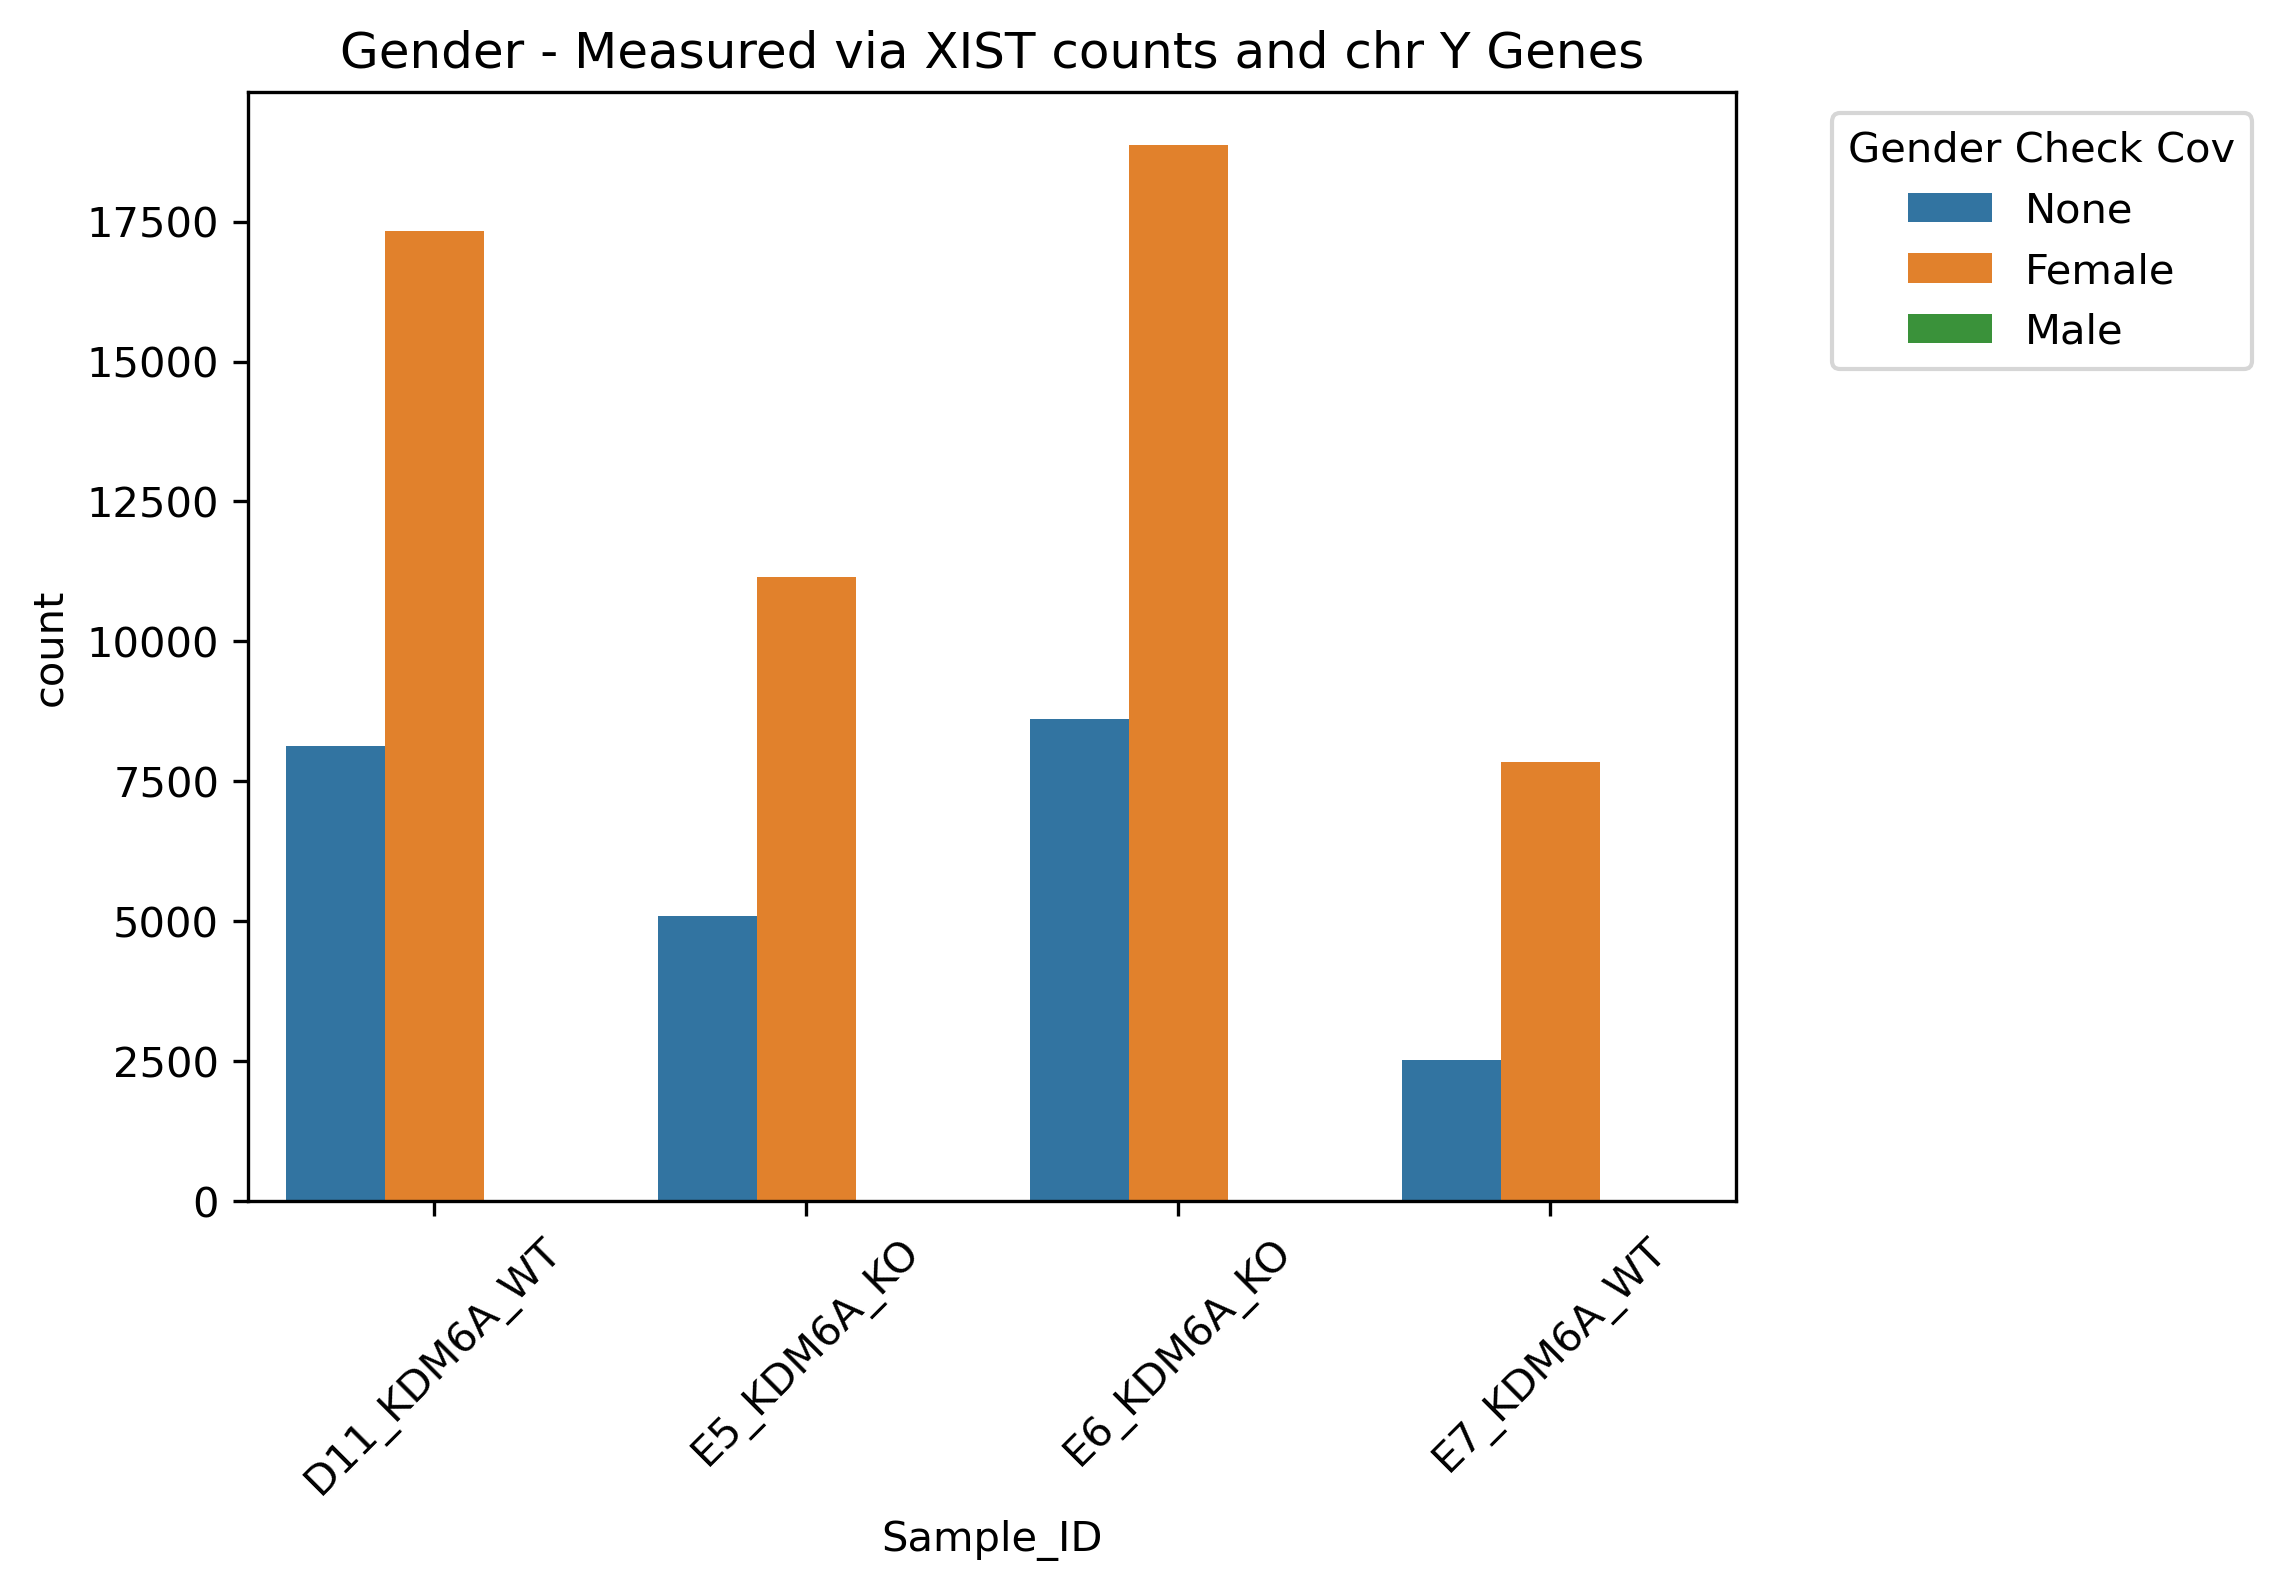

In [21]:
sb.countplot(data=adata.obs, x ='Sample_ID',hue='gender_check_cov')
plt.legend(title='Gender Check Cov', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation = 45)
plt.title('Gender - Measured via XIST counts and chr Y Genes')

# Cell cycle scores

### Downloading the list of cell cycle genes

In [22]:
!if [ ! -f /data/regev_lab_cell_cycle_genes.txt ]; then curl -o ./data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   556  100   556    0     0   2237      0 --:--:-- --:--:-- --:--:--  2232


## Marking cell cycle genes

#### Steps followed

1. Loading genes and captilizing 
2. Printing the length of cell cycle genes list
3. Split genes into 2 lists (#First 43 genes,#Gene 43 to end)
4. Filtering cell cycle genes only if present in processed_gene_names
5. Print the list of cell cycle genes observed in our data

In [23]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
cell_cycle_genes = [gene.capitalize() for gene in cell_cycle_genes]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
94


In [24]:
cell_cycle_genes

['Mcm5',
 'Pcna',
 'Tyms',
 'Fen1',
 'Mcm2',
 'Mcm4',
 'Rrm1',
 'Ung',
 'Gins2',
 'Mcm6',
 'Cdca7',
 'Dtl',
 'Prim1',
 'Uhrf1',
 'Hells',
 'Rfc2',
 'Rpa2',
 'Nasp',
 'Rad51ap1',
 'Gmnn',
 'Wdr76',
 'Slbp',
 'Ccne2',
 'Ubr7',
 'Pold3',
 'Msh2',
 'Atad2',
 'Rad51',
 'Rrm2',
 'Cdc45',
 'Cdc6',
 'Exo1',
 'Tipin',
 'Dscc1',
 'Blm',
 'Casp8ap2',
 'Usp1',
 'Clspn',
 'Pola1',
 'Chaf1b',
 'Brip1',
 'E2f8',
 'Hmgb2',
 'Cdk1',
 'Nusap1',
 'Ube2c',
 'Birc5',
 'Tpx2',
 'Top2a',
 'Ndc80',
 'Cks2',
 'Nuf2',
 'Cks1b',
 'Mki67',
 'Tmpo',
 'Cenpf',
 'Tacc3',
 'Smc4',
 'Ccnb2',
 'Ckap2l',
 'Ckap2',
 'Aurkb',
 'Bub1',
 'Kif11',
 'Anp32e',
 'Tubb4b',
 'Gtse1',
 'Kif20b',
 'Hjurp',
 'Cdca3',
 'Cdc20',
 'Ttk',
 'Cdc25c',
 'Kif2c',
 'Rangap1',
 'Ncapd2',
 'Dlgap5',
 'Cdca2',
 'Cdca8',
 'Ect2',
 'Kif23',
 'Hmmr',
 'Aurka',
 'Psrc1',
 'Anln',
 'Lbr',
 'Ckap5',
 'Cenpe',
 'Ctcf',
 'Nek2',
 'G2e3',
 'Gas2l3',
 'Cbx5',
 'Cenpa']

### Creating basic anndata and normalization for cell cycle score calculation

In [25]:
adata_log = anndata.AnnData(X = adata.X,  var = adata.var, obs = adata.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
['Fhl2', 'Camk1d', 'Gsn', 'Ttn', 'Cst3', 'Pdlim5', 'Gm12381', 'Ptprd', 'Nppa', 'Pcdh7', 'Kcnd2', 'Igkc', 'Cacna1c', 'Mgp', 'Hbb-bt', 'Hbb-bs', 'Dlc1', 'Ngp', 'Hba-a1', 'Hba-a2', 'Ighg2b', 'Ighm', 'Ryr2', 'Pde4d', 'Myh6', 'Gpc6', 'Rbfox1', 'Zbtb20', 'Gm42418', 'AY036118', 'Slc8a1', 'Cd74', 'Malat1', 'Prkg1', 'Fgf13', 'Dmd', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3']
    finished (0:00:00)


### Cell cycle score calculation

In [26]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)

adata.obs['S_score'] = adata_log.obs['S_score']
adata.obs['G2M_score'] = adata_log.obs['G2M_score']
adata.obs['phase'] = adata_log.obs['phase']

adata

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    512 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    515 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


AnnData object with n_obs × n_vars = 79592 × 32285
    obs: 'sample_name', 'Genotype', 'Sample_ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'percent_chrY', 'XIST-counts', 'XIST-percentage', 'gender_check_cov', 'S_score', 'G2M_score', 'phase'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Sample_ID_colors'
    layers: 'raw_counts'

In [27]:
cell_cycle_counts = adata.obs['phase'].value_counts()

cell_cycle_counts

phase
G1     41414
S      20386
G2M    17792
Name: count, dtype: int64

Text(0.5, 1.0, 'Cell cycle phase counts')

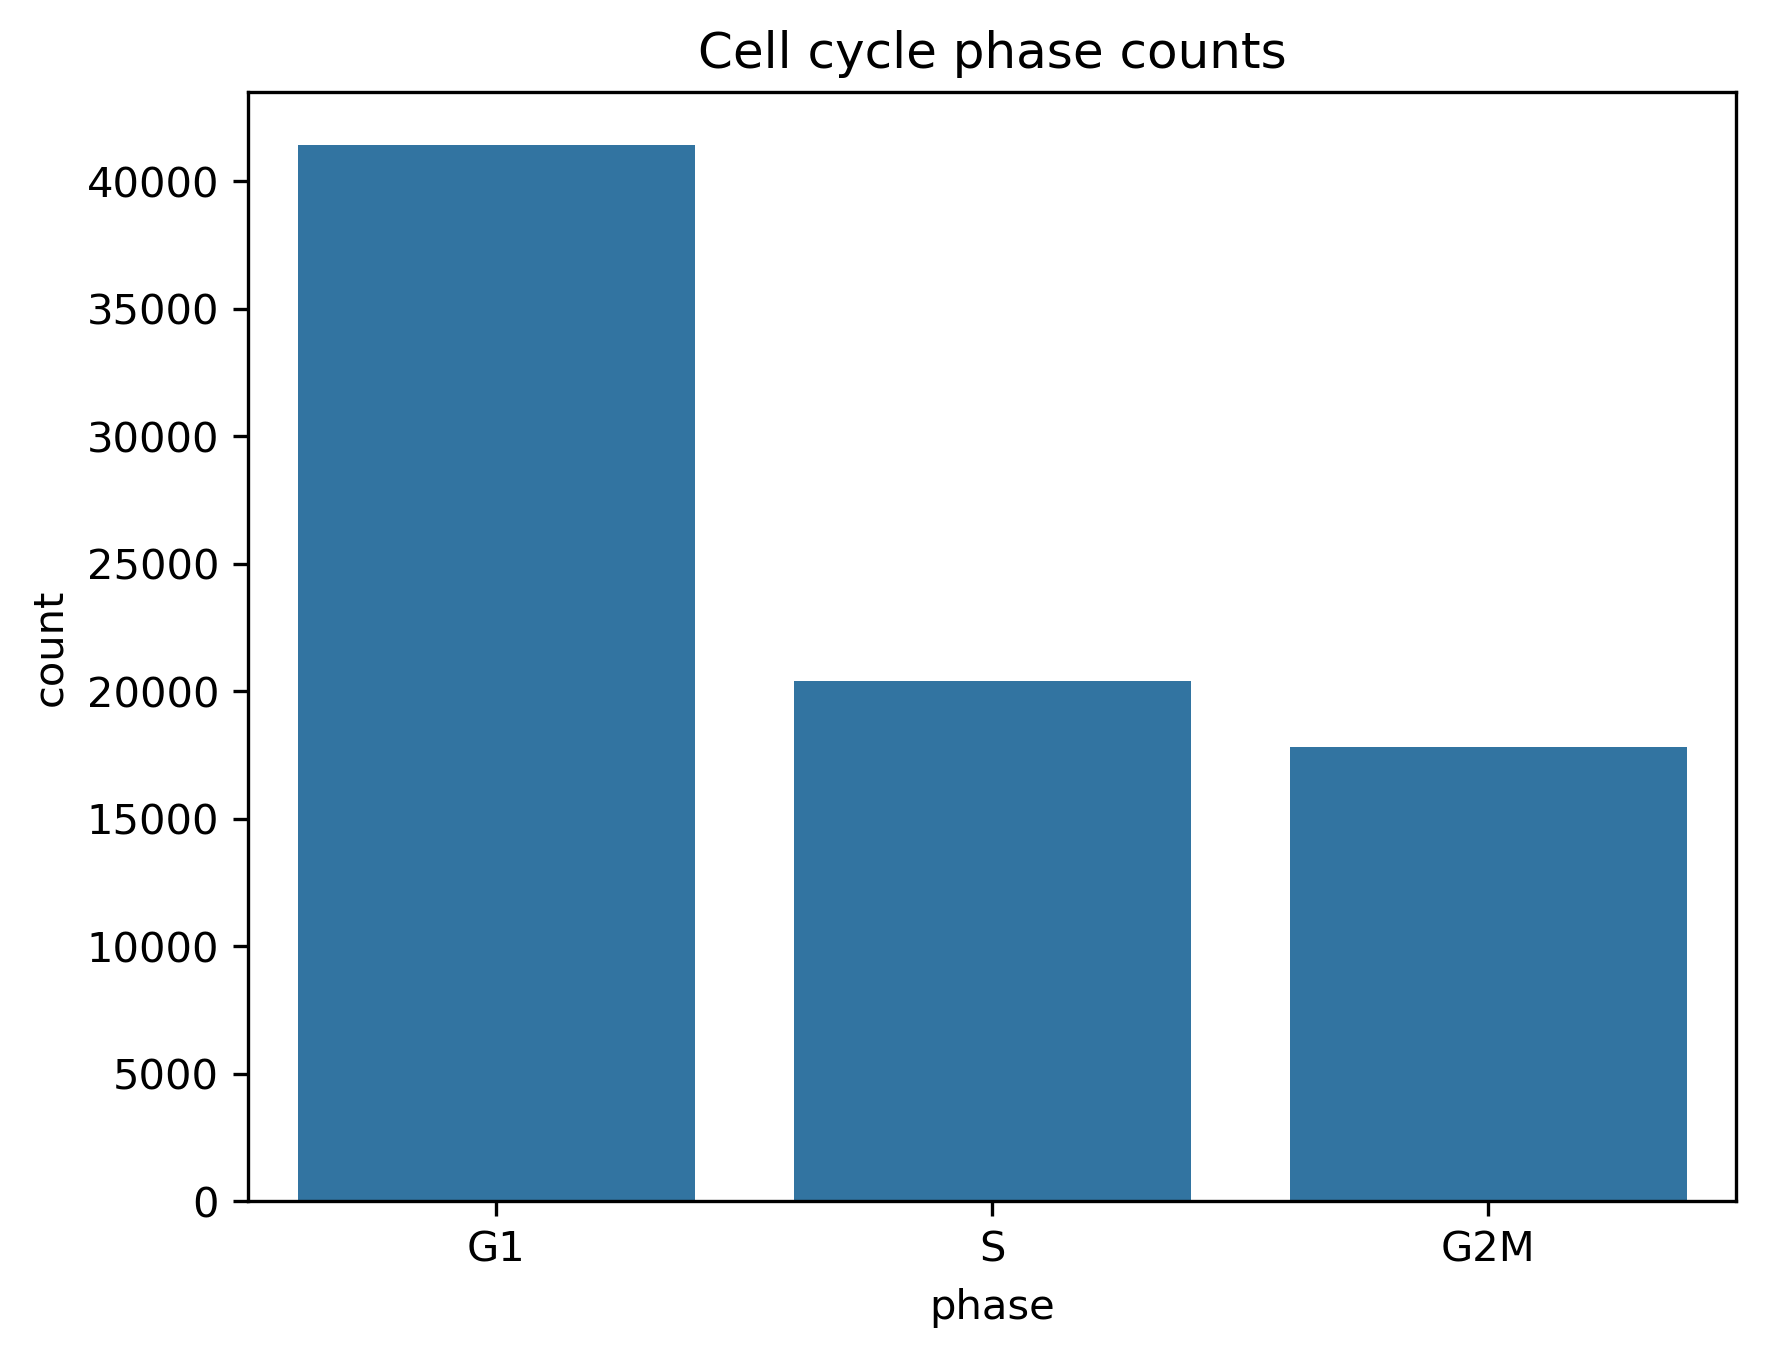

In [28]:
sb.countplot(data=adata.obs, x='phase')
plt.title('Cell cycle phase counts')

Text(0.5, 1.0, 'Cell cycle phase - Sample')

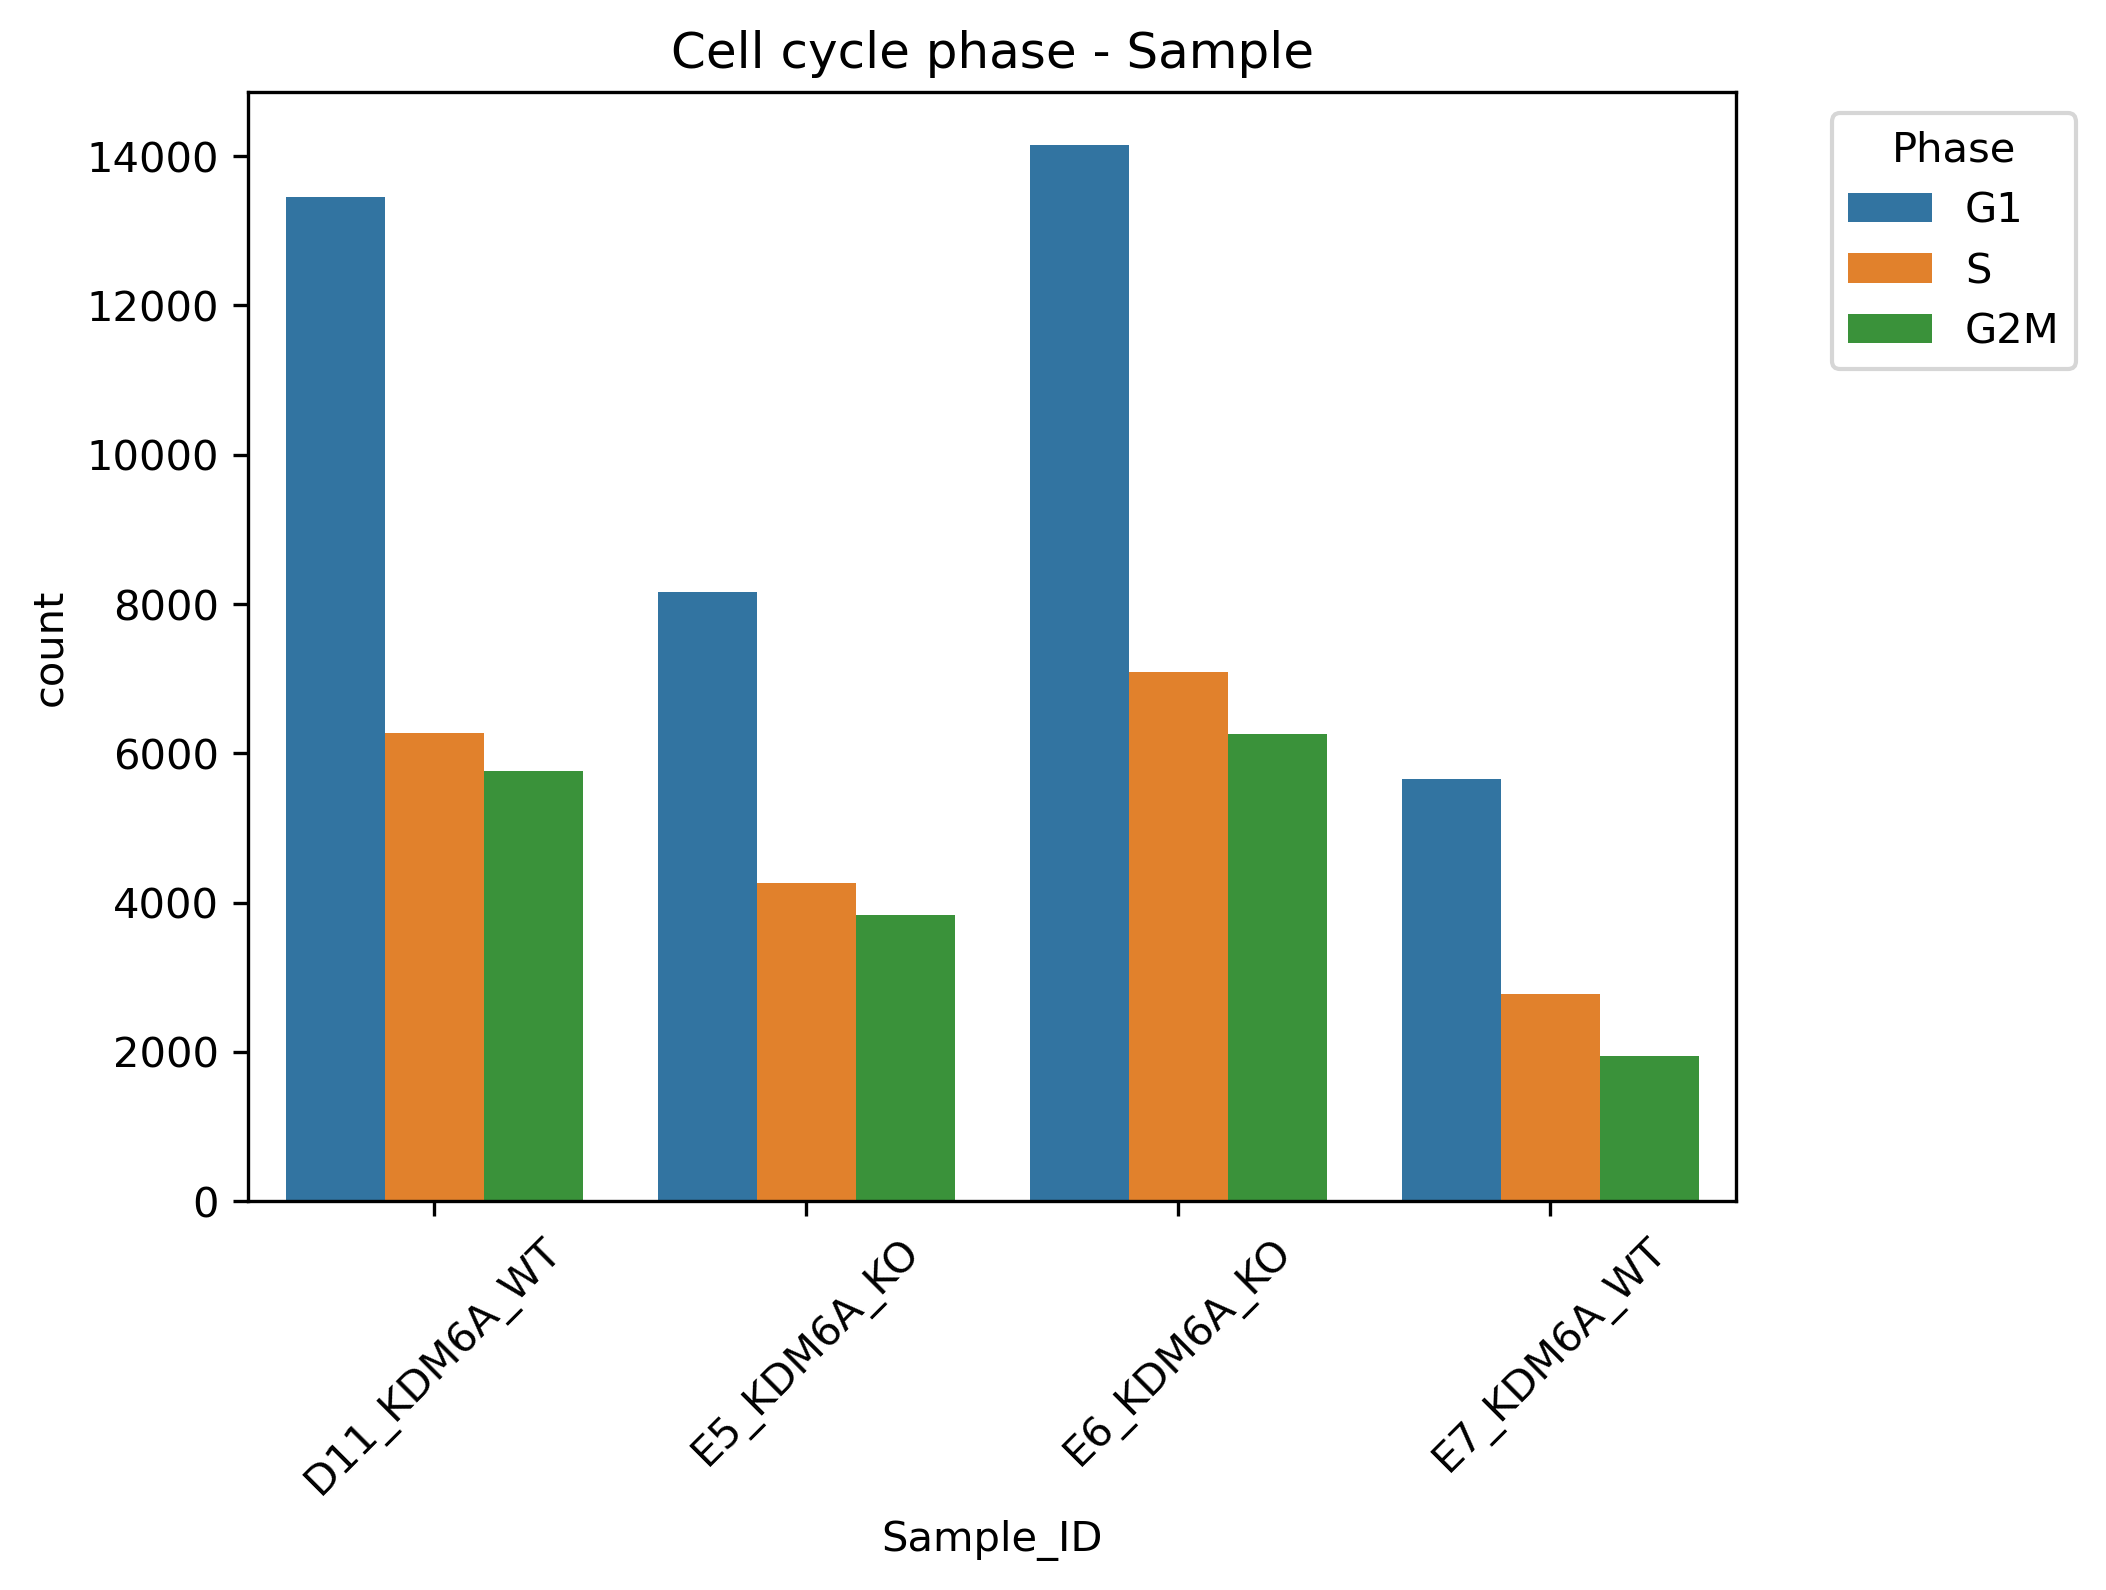

In [29]:
sb.countplot(data=adata.obs, x='Sample_ID', hue= 'phase')
plt.legend(title = 'Phase',bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.title('Cell cycle phase - Sample')

# Data Export

In [30]:
adata.obs['predicted_doublets'] = adata.obs['predicted_doublets'].astype('category')

In [31]:
adata.write(f'./data/matthias_raw_basic_qc_covariates_{timestamp}.h5ad')